In [1]:
from torchinfo import summary
import torch
import mlflow
import mlflow.pytorch
import os
# connect the experiment to the tracking server
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# set the experiment name
mlflow.set_experiment("SPAD-ConvNext-model")

# enable autologging
mlflow.pytorch.autolog()


In [2]:
# Set up logging to a file
import logging

# Get current working directory
log_file_path = os.path.join(os.getcwd(), 'training.log')

# Set up the logger manually
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Remove all previous handlers (important in Jupyter)
logger.handlers.clear()

# Create and add FileHandler
file_handler = logging.FileHandler(log_file_path, mode='w')
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Optional: also log to console
console_handler = logging.StreamHandler()
console_handler.setFormatter(formatter)
logger.addHandler(console_handler)

In [3]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    """
    Set the seed for reproducibility in PyTorch, NumPy, and Python's random module.
    Ensures deterministic behavior on CPU, CUDA, and MPS.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  # Works for CPU & MPS

    if torch.backends.mps.is_available():
        logging.info("MPS backend is available. It uses the global PyTorch seed.")

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # Multi-GPU
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    torch.use_deterministic_algorithms(True, warn_only=True)
    logging.info("Deterministic algorithms set to True.")
    logging.info("Random seed set to: %d", seed)

# Example usage
global_seed = 42
set_seed(global_seed)

2025-04-13 14:15:21,067 - INFO - MPS backend is available. It uses the global PyTorch seed.
2025-04-13 14:15:21,068 - INFO - Deterministic algorithms set to True.
2025-04-13 14:15:21,069 - INFO - Random seed set to: 42


In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class SPAD_DATASET(Dataset):
    def __init__(self, image_dir, depth_dir, transform=None, depth_transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.depth_dir = depth_dir
        self.transform = transform
        self.depth_transform = depth_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Load Ground Truth depth Image
        depth_path = os.path.join(self.depth_dir, img_name)
        depth_image = Image.open(depth_path).convert('L')

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.depth_transform:
            depth_image = self.depth_transform(depth_image)

        return image, depth_image

# Separate transforms
input_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

depth_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

g = torch.Generator()
g.manual_seed(42)

# Create Dataloaders
dataloader_train_batch = 4
dataloader_eval_batch = 4

train_dataset = SPAD_DATASET(image_dir='competition-data/training-images', depth_dir='competition-data/training-depths',
                         transform=input_transform, depth_transform=depth_transform)
train_loader = DataLoader(train_dataset, batch_size=dataloader_train_batch, shuffle=False, num_workers=0, generator=g)

val_dataset = SPAD_DATASET(image_dir='competition-data/validation-images', depth_dir='competition-data/validation-depths',
                       transform=input_transform, depth_transform=depth_transform)
val_loader = DataLoader(val_dataset, batch_size=dataloader_eval_batch, shuffle=False, num_workers=0, generator=g)

In [5]:
class SPAD_DATASET_test(Dataset):
    def __init__(self, image_dir, transform=None):
        """
        Custom dataloader for SPAD binary png images dataset.

        Args:
            image_dir (str): Path to image directory (train, val, test).
            depth_dir (str): Path to corresponding depth map directory.
            transform (callable, optional): Transformations for images.
            edge_transform (callable, optional): Transformations for edge maps.
        """
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load Image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, img_name
    
# Create Dataloaders for test dataset
test_dataset = SPAD_DATASET_test(image_dir='competition-data/testing-images', transform=input_transform)
test_loader = DataLoader(test_dataset, batch_size=dataloader_eval_batch, shuffle=False, num_workers=0, generator=g)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Squeeze-and-Excitation Block
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# ConvNeXt Block with Residual
class ConvNeXtBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.pwconv = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.Linear(4 * dim, dim)
        )
        self.gamma = nn.Parameter(1e-6 * torch.ones(dim))
        
    def forward(self, x):
        identity = x
        x = self.dwconv(x)
        
        # Maintain spatial dimensions
        B, C, H, W = x.shape
        
        # Channel-first to channel-last with contiguous memory
        x = x.permute(0, 2, 3, 1).contiguous()  # [B, H, W, C]
        x = self.norm(x)
        x = self.pwconv(x)
        x = x.permute(0, 3, 1, 2).contiguous()  # [B, C, H, W]
        
        # Ensure spatial dimension match
        return identity[:, :, :H, :W] + self.gamma[None,:,None,None] * x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels + skip_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, groups=out_channels),  # Depthwise Conv
            nn.Conv2d(out_channels, out_channels, kernel_size=1),  # Pointwise Conv
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        self.attention = SEBlock(out_channels)  # Squeeze-and-Excitation Block for channel attention

    def forward(self, x, skip):
        # Interpolate x to match skip connection spatial dimensions
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        # Concatenate x and skip connection along the channel dimension
        x = torch.cat([x.contiguous(), skip.contiguous()], dim=1)
        x = self.conv(x)
        x = self.attention(x)
        return x

# Add lambda layer for inline permutations
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func
    def forward(self, x):
        return self.func(x)

class ConvNeXtEncoderDecoder(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        dims = [96, 192, 384, 768]

        # Stem remains corrected as before
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, dims[0], 4, stride=4),
            nn.Conv2d(dims[0], dims[0], 3, padding=1),
            Lambda(lambda x: x.permute(0, 2, 3, 1)),
            nn.LayerNorm(dims[0], eps=1e-6),
            Lambda(lambda x: x.permute(0, 3, 1, 2)),
            nn.GELU()
        )

        # Corrected encoder stages with proper LayerNorm handling
        self.enc1 = nn.Sequential(  # ADDED MISSING ENC1
            *[ConvNeXtBlock(dims[0]) for _ in range(3)]
        )

        self.enc2 = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(dims[0], dims[1], 2, stride=2),
                Lambda(lambda x: x.permute(0, 2, 3, 1)),  # Channel-last
                nn.LayerNorm(dims[1], eps=1e-6),
                Lambda(lambda x: x.permute(0, 3, 1, 2)),  # Channel-first
            ),
            *[ConvNeXtBlock(dims[1]) for _ in range(3)]
        )

        self.enc3 = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(dims[1], dims[2], 2, stride=2),
                Lambda(lambda x: x.permute(0, 2, 3, 1)),  # Channel-last
                nn.LayerNorm(dims[2], eps=1e-6),
                Lambda(lambda x: x.permute(0, 3, 1, 2)),  # Channel-first
            ),
            *[ConvNeXtBlock(dims[2]) for _ in range(9)]
        )

        self.enc4 = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(dims[2], dims[3], 2, stride=2),
                Lambda(lambda x: x.permute(0, 2, 3, 1)),  # Channel-last
                nn.LayerNorm(dims[3], eps=1e-6),
                Lambda(lambda x: x.permute(0, 3, 1, 2)),  # Channel-first
            ),
            *[ConvNeXtBlock(dims[3]) for _ in range(3)]
        )
        
        # Decoder
        self.dec3 = DecoderBlock(dims[3], dims[2], dims[2])
        self.dec2 = DecoderBlock(dims[2], dims[1], dims[1])
        self.dec1 = DecoderBlock(dims[1], dims[0], dims[0])
        
        # Heads
        self.head_main = nn.Conv2d(dims[0], 1, 1)
        self.head_aux3 = nn.Conv2d(dims[2], 1, 1)
        self.head_aux2 = nn.Conv2d(dims[1], 1, 1)
        self.head_aux1 = nn.Conv2d(dims[0], 1, 1)
        
        # Learnable weights
        self.weights = nn.Parameter(torch.ones(4))
        
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        # Encoder
        x0 = self.stem(x)  # 1/4
        x1 = self.enc1(x0)
        x2 = self.enc2(x1)  # 1/8
        x3 = self.enc3(x2)  # 1/16
        x4 = self.enc4(x3)  # 1/32
        
        # Decoder
        d3 = self.dec3(x4, x3)  # 1/16
        d2 = self.dec2(d3, x2)  # 1/8
        d1 = self.dec1(d2, x1)  # 1/4
        
        # Outputs
        main = self.head_main(F.interpolate(d1, scale_factor=4, mode='bilinear'))
        aux3 = self.head_aux3(F.interpolate(d3, scale_factor=16, mode='bilinear'))
        aux2 = self.head_aux2(F.interpolate(d2, scale_factor=8, mode='bilinear'))
        aux1 = self.head_aux1(F.interpolate(d1, scale_factor=4, mode='bilinear'))
        
        # Weighted fusion
        weights = F.softmax(self.weights, dim=0)
        fused = weights[0]*main + weights[1]*aux1 + weights[2]*aux2 + weights[3]*aux3
        
        return fused, [main, aux1, aux2, aux3]

    
# model = ConvNeXtEncoderDecoder()
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# total_params_millions = total_params / 1e6
# total_params_millions

In [7]:
def train(model, train_loader, criterion, optimizer, device, epoch):
    model.train()
    
    total_fused_loss = 0.0
    total_main_loss = 0.0
    total_a1_loss = 0.0
    total_a2_loss = 0.0
    total_a3_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        fused, aux_outputs = model(images)  # Corrected output unpacking
        main, a1, a2, a3 = aux_outputs  # Get individual outputs
        
        # Calculate losses for logging only
        with torch.no_grad():  # No gradient needed for metrics
            loss_main = criterion(main, labels)
            loss_a1 = criterion(a1, labels)
            loss_a2 = criterion(a2, labels)
            loss_a3 = criterion(a3, labels)
        
        # Backpropagate only through the fused output
        fused_loss = criterion(fused, labels)
        fused_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Track losses
        total_fused_loss += fused_loss.item()
        total_main_loss += loss_main.item()
        total_a1_loss += loss_a1.item()
        total_a2_loss += loss_a2.item()
        total_a3_loss += loss_a3.item()

    # Average and log metrics
    avg_losses = {
        "train_fused_loss": total_fused_loss / len(train_loader),
        "train_main_loss": total_main_loss / len(train_loader),
        "train_aux1_loss": total_a1_loss / len(train_loader),
        "train_aux2_loss": total_a2_loss / len(train_loader),
        "train_aux3_loss": total_a3_loss / len(train_loader)
    }
    
    for metric, value in avg_losses.items():
        mlflow.log_metric(metric, value, step=epoch+1)

    logging.info(f"Epoch {epoch+1}: Fused Loss = {avg_losses['train_fused_loss']}")



def validate(model, val_loader, criterion, device, epoch):
    model.eval()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            fused, aux_outputs = model(images)  # Correct unpacking
            loss = criterion(fused, labels)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    rmse = avg_loss**0.5  # Correct RMSE calculation if using MSE loss

    logging.info(f"Epoch {epoch+1} - Val Loss: {avg_loss:.4f}, RMSE: {rmse:.4f}")
    mlflow.log_metric("val_loss", avg_loss, step=epoch+1)
    mlflow.log_metric("val_RMSE", rmse, step=epoch+1)

    return rmse



In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0, verbose=False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.verbose = verbose
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_score is None or val_loss < self.best_score - self.min_delta:
            self.best_score = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()
            if self.verbose:
                logging.info(f"Monitored metric improved to {val_loss:.6f}")
        else:
            self.counter += 1
            if self.verbose:
                logging.info(f"Monitored metric did not improve. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    logging.warning("Early stopping triggered.")

In [9]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Initialize model
model = ConvNeXtEncoderDecoder()

criterion_train = nn.MSELoss()
criterion_val = nn.MSELoss()


# Initialize optimizer
starting_lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=starting_lr)


# Initialize learning rate scheduler
scheduler_mode = 'min'
scheduler_factor = 0.5
scheduler_patience = 2
scheduler_cooldown = 0
scheduler_min_lr = 1e-6
scheduler_threshold = 0.0001
scheduler_threshold_mode = 'abs'

scheduler = ReduceLROnPlateau(optimizer, mode=scheduler_mode,
                              factor=scheduler_factor,
                              patience=scheduler_patience,
                              cooldown=scheduler_cooldown,
                              min_lr=scheduler_min_lr,
                              threshold=scheduler_threshold,
                              threshold_mode=scheduler_threshold_mode,
                              verbose=True)

# Initialize early stopping
early_stopping_patience = scheduler_cooldown + scheduler_patience + 4
early_stopping_delta = scheduler_threshold/2
early_stopping = EarlyStopping(patience=early_stopping_patience,
                               verbose=True,
                               min_delta=early_stopping_delta)  # noqa: E501

max_num_epochs = 300

# Check device
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.backends.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
logging.info(f"Using device: {device.type}")
# Move model to device
model.to(device)


# Log params as a dictionary
params = {
    "global_seed": global_seed,
    "train_batch_size": dataloader_train_batch,
    "eval_batch_size": dataloader_eval_batch,
    # "base_c": base_c,
    "loss_function": "MSELoss",
    "learning_rate": starting_lr,
    "optimizer": "Adam",
    "scheduler_mode": scheduler_mode,
    "scheduler_factor": scheduler_factor,
    "scheduler_patience": scheduler_patience,
    "scheduler_cooldown": scheduler_cooldown,
    "scheduler_min_lr": scheduler_min_lr,
    "scheduler_therhold": scheduler_threshold,
    "scheduler_threshold_mode": scheduler_threshold_mode,
    "scheduler": "ReduceLROnPlateau",
    "early_stopping_patience": early_stopping_patience,
    "early_stopping_delta": early_stopping_delta,
    "max_epochs": max_num_epochs,
    "device": device.type,
}


/opt/miniconda3/envs/MCV/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-04-13 14:15:24,425 - INFO - Using device: mps


In [15]:
import os
import torch
from PIL import Image
import torchvision.transforms as transforms

def predict_and_save(model, dataloader, device, output_dir='competition-data/predicted_depths'):
    model.eval()
    os.makedirs(output_dir, exist_ok=True)
    transform = transforms.ToPILImage()

    with torch.no_grad():
        for batch_idx, (images, filenames) in enumerate(dataloader):
            images = images.to(device)
            
            # Forward pass - extract fused output (first tuple element)
            fused_output, _ = model(images)  # Explicitly unpack tuple
            
            # Denormalize if inputs were normalized to [-1, 1]
            fused_output = fused_output * 0.5 + 0.5  # Remove if using different normalization
            
            # Ensure correct shape: (B, 1, H, W) -> (B, H, W)
            fused_output = fused_output.squeeze(1)
            
            # Convert to CPU once per batch for efficiency
            fused_output = fused_output.cpu()

            for idx in range(fused_output.shape[0]):
                depth_map = fused_output[idx]  # (H, W)
                
                # Convert to uint8 and scale to 0-255
                depth_map = (depth_map * 255).clamp(0, 255).to(torch.uint8)
                
                # Handle filename with extension
                original_name = os.path.basename(filenames[idx])  # Extract filename only
                output_path = os.path.join(output_dir, original_name)
                
                # Create subdirectories if needed
                os.makedirs(os.path.dirname(output_path), exist_ok=True)
                
                # Save as single-channel PNG
                Image.fromarray(depth_map.numpy()).save(output_path)
                print(f"Saved {original_name}")


In [ ]:
run_id = None
# Start MLflow run
with mlflow.start_run() as run:
    run_id = run.info.run_id
    logging.info(f"Started MLflow run with ID: {run_id}")

    ###########################
    # Log the model parameters
    ###########################
    try:
        mlflow.log_params(params)
        logging.info("Logged params to MLflow")
    except Exception as e:
        logging.error(f"Failed to log parameters: {e}")
        raise
    ###########################
    # Save model summary
    ###########################
    try:
        model_summary = summary(model, input_size=(1, 1, 256, 256), device=device.type)

        with open("model_report.txt", "w") as f:
            f.write("### MODEL ARCHITECTURE ###\n")
            f.write(str(model))
            f.write("\n\n### MODEL SUMMARY ###\n")
            f.write(str(model_summary))

        mlflow.log_artifact("model_report.txt")
        logging.info("Model report logged to MLflow")
        os.remove("model_report.txt")
    except Exception as e:
        logging.error(f"Failed to log model report: {e}")
        raise
    
    logging.info("Starting training...")

    ###########################
    # Training loop
    ###########################
    best_metric = float('inf')
    best_save_epoch = 0

    for epoch in range(max_num_epochs):
        try:
            current_lr = optimizer.param_groups[0]['lr']
            logging.info(f"Epoch {epoch + 1}, LR: {current_lr}")
            mlflow.log_metric("learning_rate", current_lr, step=epoch + 1)

            train(model, train_loader, criterion_train, optimizer, device, epoch)
            rmse = validate(model, val_loader, criterion_val, device, epoch)

            scheduler.step(rmse)

            # Save best model
            if rmse < best_metric:
                best_metric = rmse
                best_save_epoch = epoch
                mlflow.pytorch.log_model(model, artifact_path="best_model")
                logging.info(f"Improved RMSE: {rmse:.6f}. Logged best model to MLflow.")

            # Log latest model
            mlflow.pytorch.log_model(model, artifact_path="latest_model")

            # Early stopping
            early_stopping(rmse, model)

            if early_stopping.early_stop:
                mlflow.log_param("best_model_saved_at", best_save_epoch)
                mlflow.log_param("early_stopping_triggered_at", epoch)
                logging.warning("Early stopping triggered. Stopping training.")
                break

        except Exception as e:
            logging.error(f"Training loop failed at epoch {epoch}: {e}")
            raise
            break

2025-04-13 14:15:26,262 - INFO - Started MLflow run with ID: 389a7de5559744969fd60d8e1ef984b1
2025-04-13 14:15:26,269 - INFO - Logged params to MLflow
2025-04-13 14:15:26,894 - INFO - Model report logged to MLflow
2025-04-13 14:15:26,894 - INFO - Starting training...
2025-04-13 14:15:26,895 - INFO - Epoch 1, LR: 0.001
2025-04-13 14:44:50,698 - INFO - Epoch 1: Fused Loss = 0.1890999801840152
2025-04-13 14:45:39,941 - INFO - Epoch 1 - Val Loss: 0.1797, RMSE: 0.4239
2025/04/13 14:45:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-04-13 14:45:47,984 - INFO - Improved RMSE: 0.423855. Logged best model to MLflow.
2025/04/13 14:45:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025-04-13 14:45:53,365 - INFO - Monitored metric imp

🏃 View run wise-horse-334 at: http://127.0.0.1:5000/#/experiments/331812621290199786/runs/389a7de5559744969fd60d8e1ef984b1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/331812621290199786


KeyboardInterrupt: 

In [ ]:
with mlflow.start_run(run_id=run_id):
    #########################################################
    # log the mlflow_run.log file
    #########################################################
    try:
        # Flush and close all handlers before logging the file
        for handler in logger.handlers:
            handler.flush()
            handler.close()

        mlflow.log_artifact("training.log")
        logging.info("Logged mlflow_run.log to MLflow")

        # Now it's safe to remove the log file
        os.remove("training.log")

        # Clear logger handlers
        logger.handlers.clear()
    except Exception as e:
        print(f"Failed to log mlflow_run.log to MLflow: {e}")
        raise

    
    #########################################################
    # Prediction phase
    #########################################################
    logging.info("Starting prediction...")
    try:
        # Load best model from MLflow artifacts
        model_uri = f"runs:/{run.info.run_id}/best_model"
        best_model = mlflow.pytorch.load_model(model_uri)
        best_model.to(device)
        best_model.eval()
        
        # Generate predictions with the best model
        predict_and_save(best_model, test_loader, 
                        device=device.type,
                        output_dir='competition-data/predicted_depths')

        # Create submission CSV
        os.chdir('competition-data')
        os.system('python imgs2csv.py')
        os.chdir('..')
        
        # Log predictions
        mlflow.log_artifact("competition-data/predictions.csv")
        logging.info("Logged final predictions.csv")
        
    except Exception as e:
        logging.error(f"Prediction phase failed: {e}")
        raise


INFO:root:Starting prediction...


Saved 16153231.png
Saved 24854972.png
Saved 5751152.png
Saved 185372.png
Saved 23254652.png
Saved 36657332.png
Saved 39757951.png
Saved 25755151.png
Saved 11252252.png
Saved 35257052.png
Saved 29255852.png
Saved 355712.png
Saved 32356472.png
Saved 6951392.png
Saved 165331.png
Saved 26955391.png
Saved 17753551.png
Saved 18253651.png
Saved 33756751.png
Saved 9251851.png
Saved 14052811.png
Saved 22954592.png
Saved 19553911.png
Saved 485972.png
Saved 39857971.png
Saved 25855171.png
Saved 21554311.png
Saved 7051411.png
Saved 8551711.png
Saved 255511.png
Saved 28555712.png
Saved 27055412.png
Saved 5851172.png
Saved 24754952.png
Saved 40058011.png
Saved 20154032.png
Saved 36357271.png
Saved 30456092.png
Saved 34256851.png
Saved 10952192.png
Saved 33856771.png
Saved 37557511.png
Saved 38057611.png
Saved 13552711.png
Saved 17853571.png
Saved 12152432.png
Saved 465931.png
Saved 31056212.png
Saved 15053012.png
Saved 41458291.png
Saved 32656531.png
Saved 16153232.png
Saved 5751151.png
Saved 248549

INFO:root:Logged final predictions.csv


🏃 View run wise-horse-334 at: http://127.0.0.1:5000/#/experiments/331812621290199786/runs/389a7de5559744969fd60d8e1ef984b1
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/331812621290199786


In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def plot_results(model, dataloader, device='mps', num_batches=2):
    model.eval()
    batch_count = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.unsqueeze(1).to(device)
            
            # Get outputs
            fused_output, side_outputs = model(images)
            main_out, aux1_out, aux2_out, aux3_out = side_outputs

            # Denormalize (assuming input was normalized to [-1, 1])
            fused_output = fused_output * 0.5 + 0.5
            main_out = main_out * 0.5 + 0.5
            aux1_out = aux1_out * 0.5 + 0.5
            aux2_out = aux2_out * 0.5 + 0.5
            aux3_out = aux3_out * 0.5 + 0.5

            # Convert to CPU
            images_cpu = images.cpu()
            labels_cpu = labels.squeeze(1).cpu()
            fused_cpu = fused_output.squeeze(1).cpu()
            main_cpu = main_out.squeeze(1).cpu()
            aux1_cpu = aux1_out.squeeze(1).cpu()
            aux2_cpu = aux2_out.squeeze(1).cpu()
            aux3_cpu = aux3_out.squeeze(1).cpu()

            for i in range(len(images)):
                plt.figure(figsize=(20, 10))
                
                # -------------------- Row 1: Inputs and Fused --------------------
                # Input image
                plt.subplot(2, 4, 1)
                input_img = images_cpu[i].squeeze().numpy()
                plt.imshow(input_img, cmap='gray')
                plt.title("Input Image", fontsize=10)
                plt.axis('off')

                # Ground truth
                plt.subplot(2, 4, 2)
                gt = labels_cpu[i].squeeze(0).numpy() 
                plt.imshow(gt, cmap='gray')
                plt.title("Ground Truth", fontsize=10)
                plt.axis('off')

                # Fused output
                plt.subplot(2, 4, 3)
                fused = (fused_cpu[i].numpy() * 255).clip(0, 255).astype('uint8')
                plt.imshow(fused, cmap='gray')
                plt.title("Fused Output", fontsize=10)
                plt.axis('off')

                # -------------------- Row 2: All Outputs --------------------
                # Main output
                plt.subplot(2, 4, 5)
                main = (main_cpu[i].numpy() * 255).clip(0, 255).astype('uint8')
                plt.imshow(main, cmap='gray')
                plt.title("Main Output", fontsize=10)
                plt.axis('off')

                # Aux1 output
                plt.subplot(2, 4, 6)
                aux1 = (aux1_cpu[i].numpy() * 255).clip(0, 255).astype('uint8')
                plt.imshow(aux1, cmap='gray')
                plt.title("Aux1 Output", fontsize=10)
                plt.axis('off')

                # Aux2 output
                plt.subplot(2, 4, 7)
                aux2 = (aux2_cpu[i].numpy() * 255).clip(0, 255).astype('uint8')
                plt.imshow(aux2, cmap='gray')
                plt.title("Aux2 Output", fontsize=10)
                plt.axis('off')

                # Aux3 output
                plt.subplot(2, 4, 8)
                aux3 = (aux3_cpu[i].numpy() * 255).clip(0, 255).astype('uint8')
                plt.imshow(aux3, cmap='gray')
                plt.title("Aux3 Output", fontsize=10)
                plt.axis('off')

                # Hide unused subplot in first row
                plt.subplot(2,4,4)
                plt.axis('off')

                plt.tight_layout()
                plt.show()

            batch_count += 1
            if batch_count >= num_batches:
                break




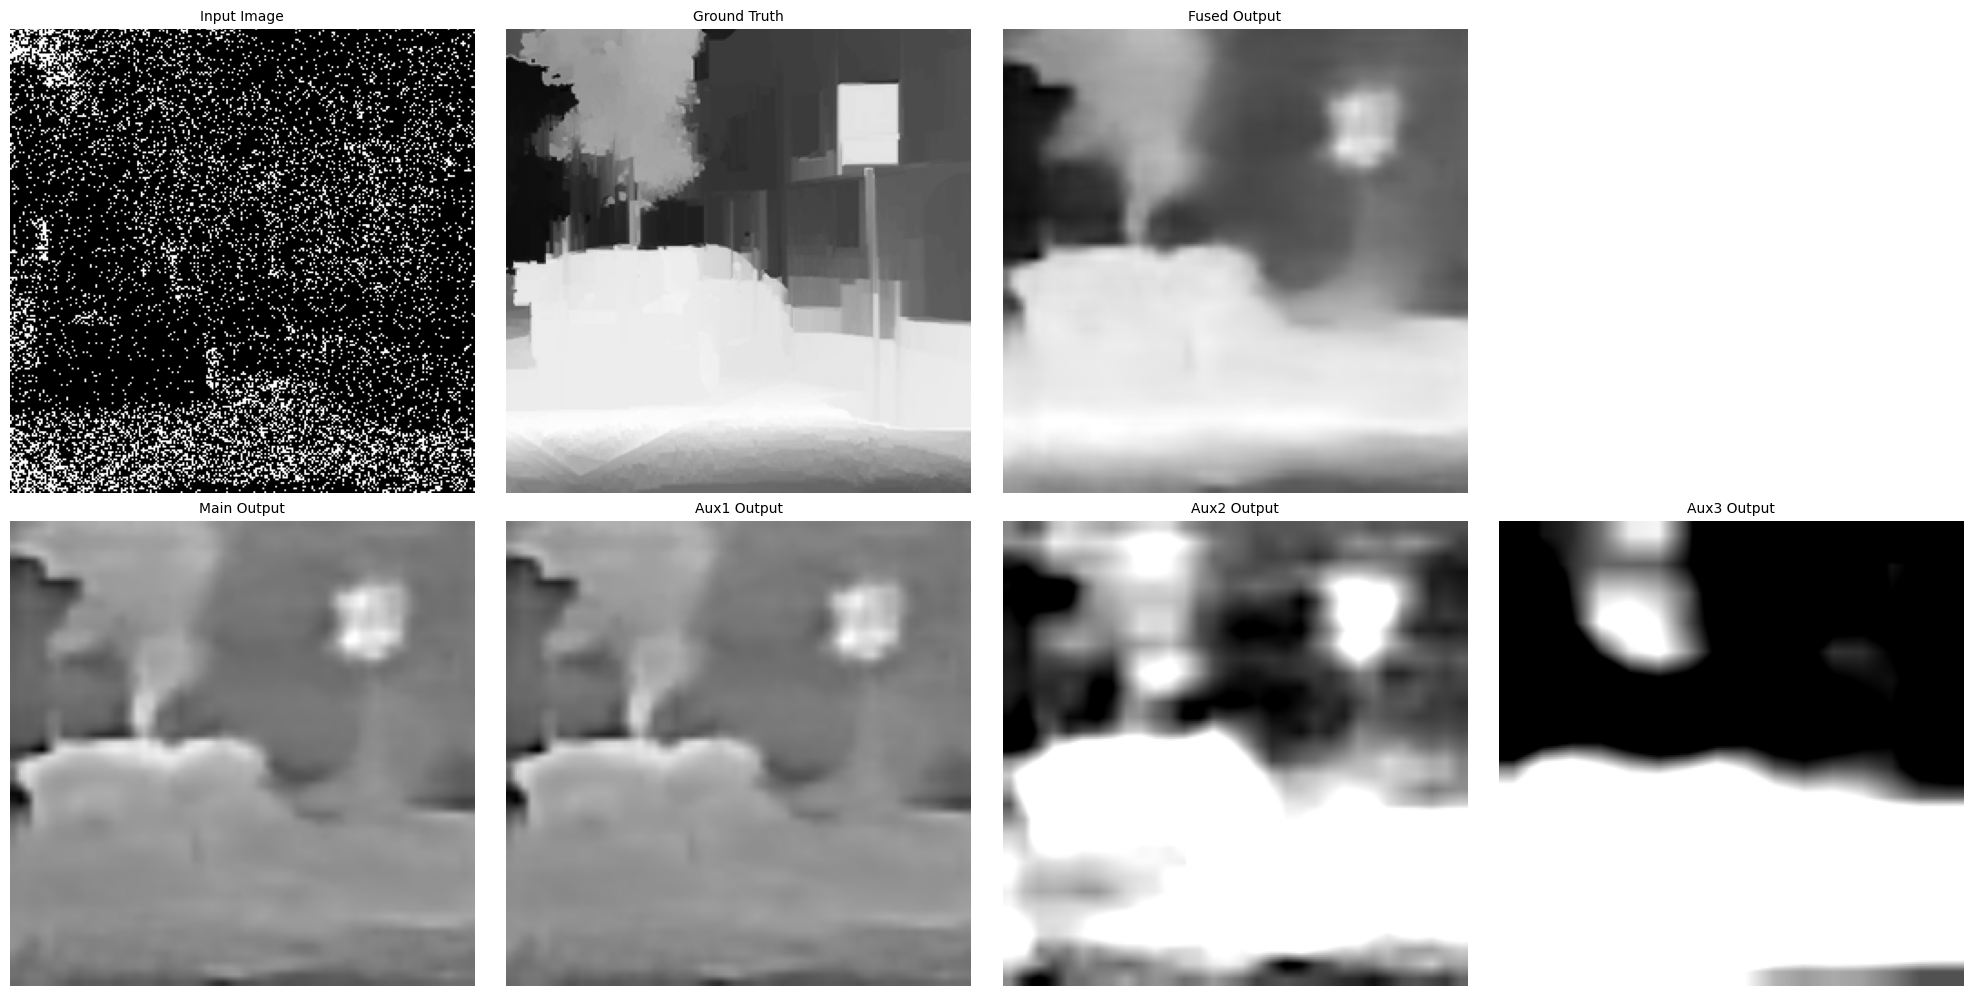

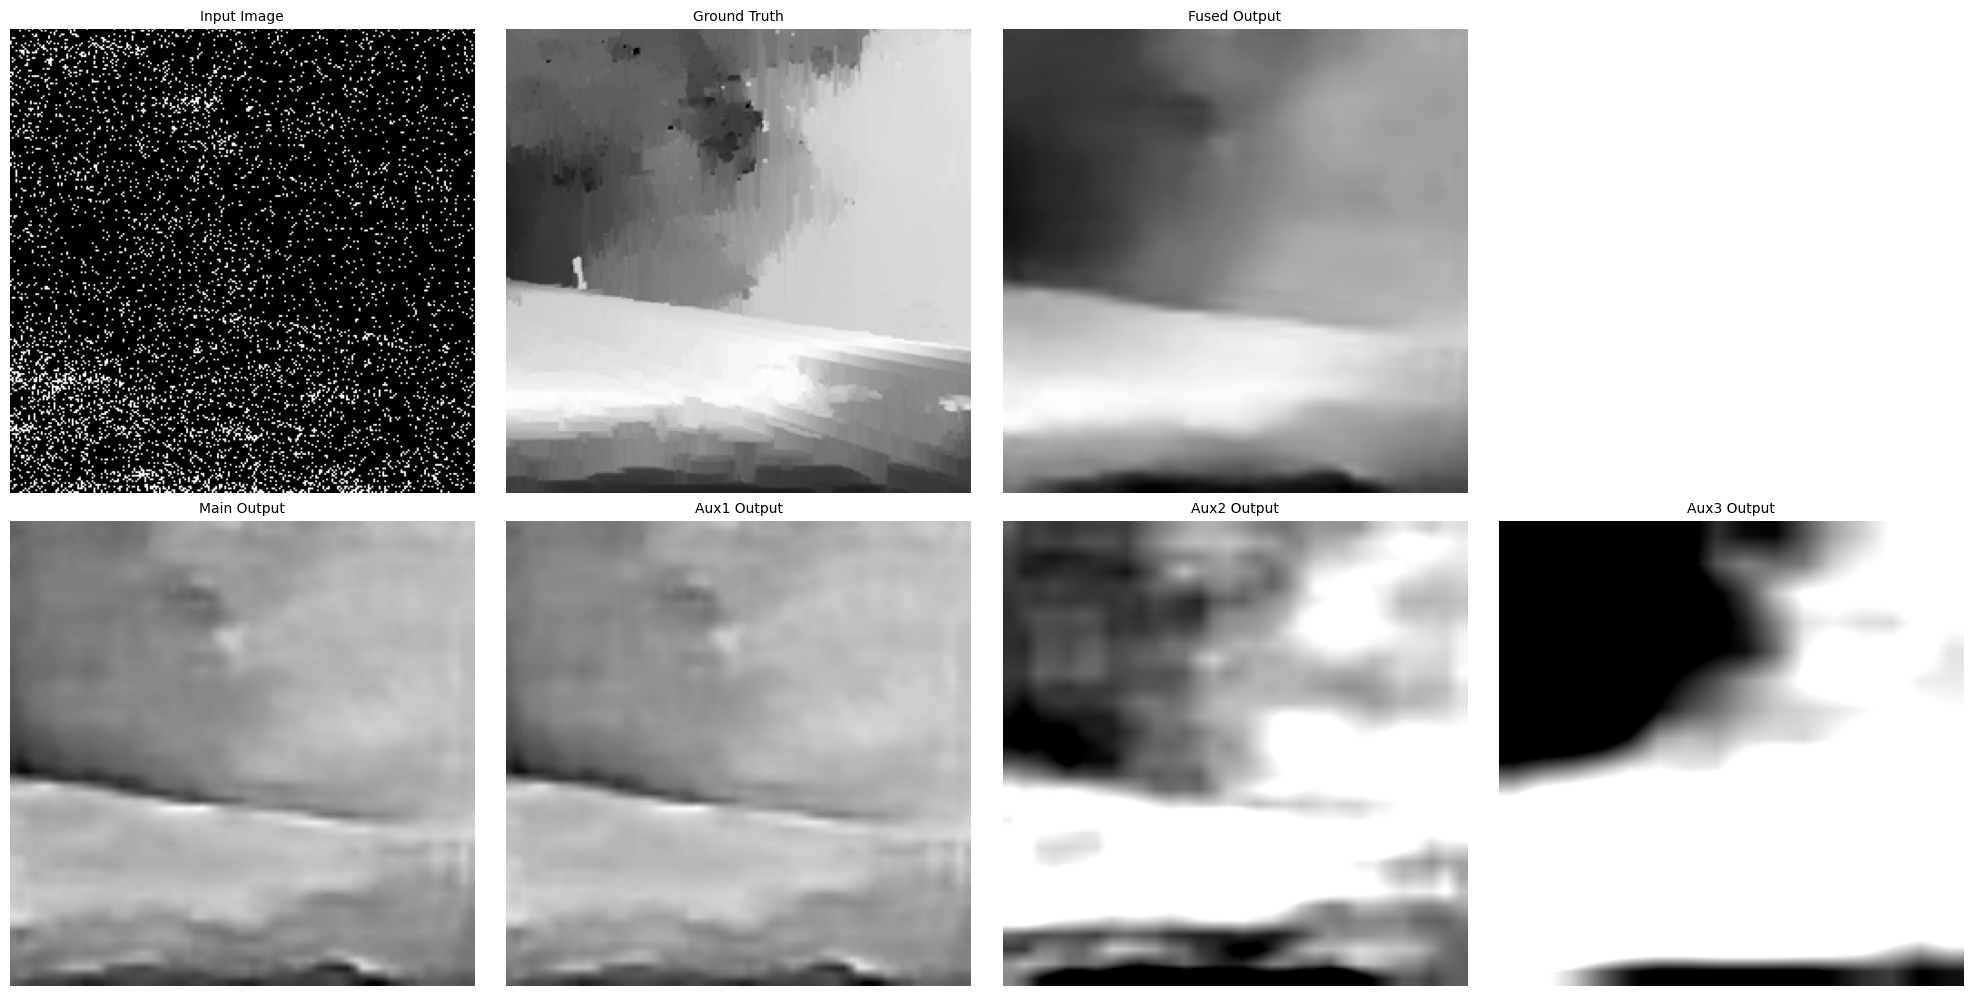

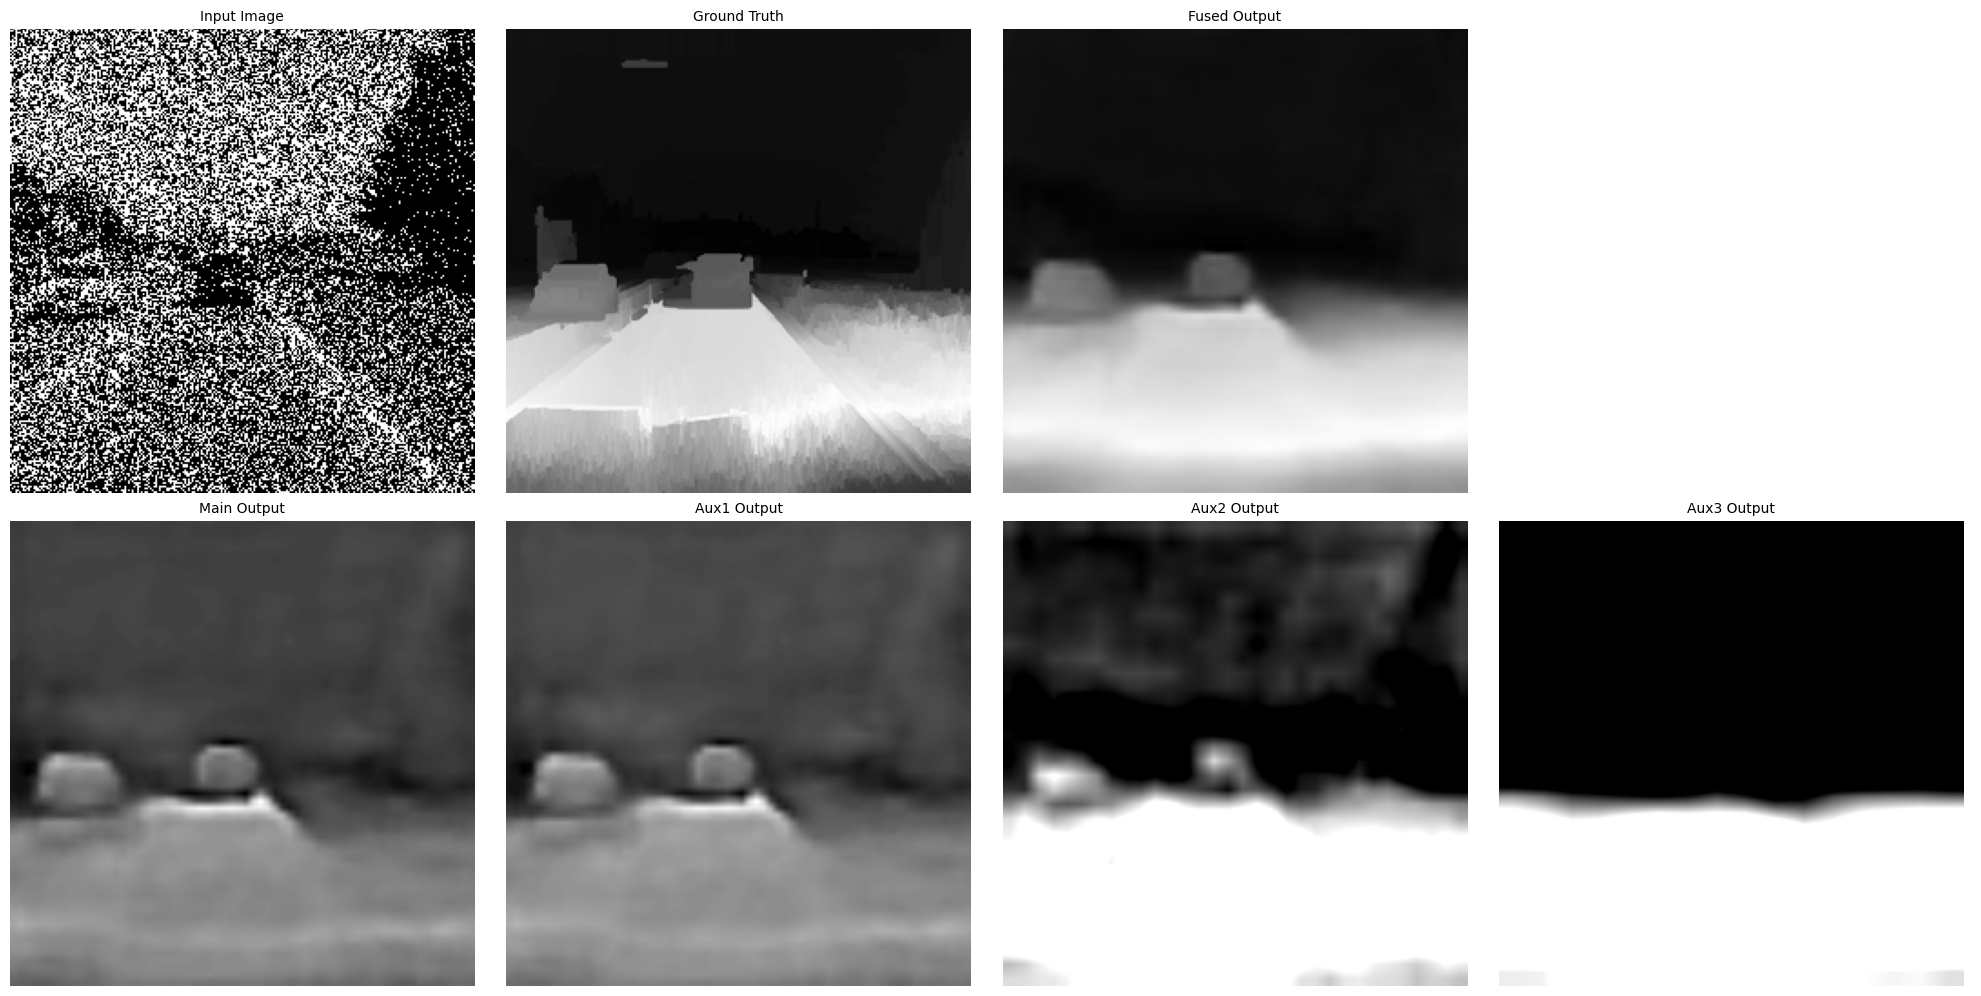

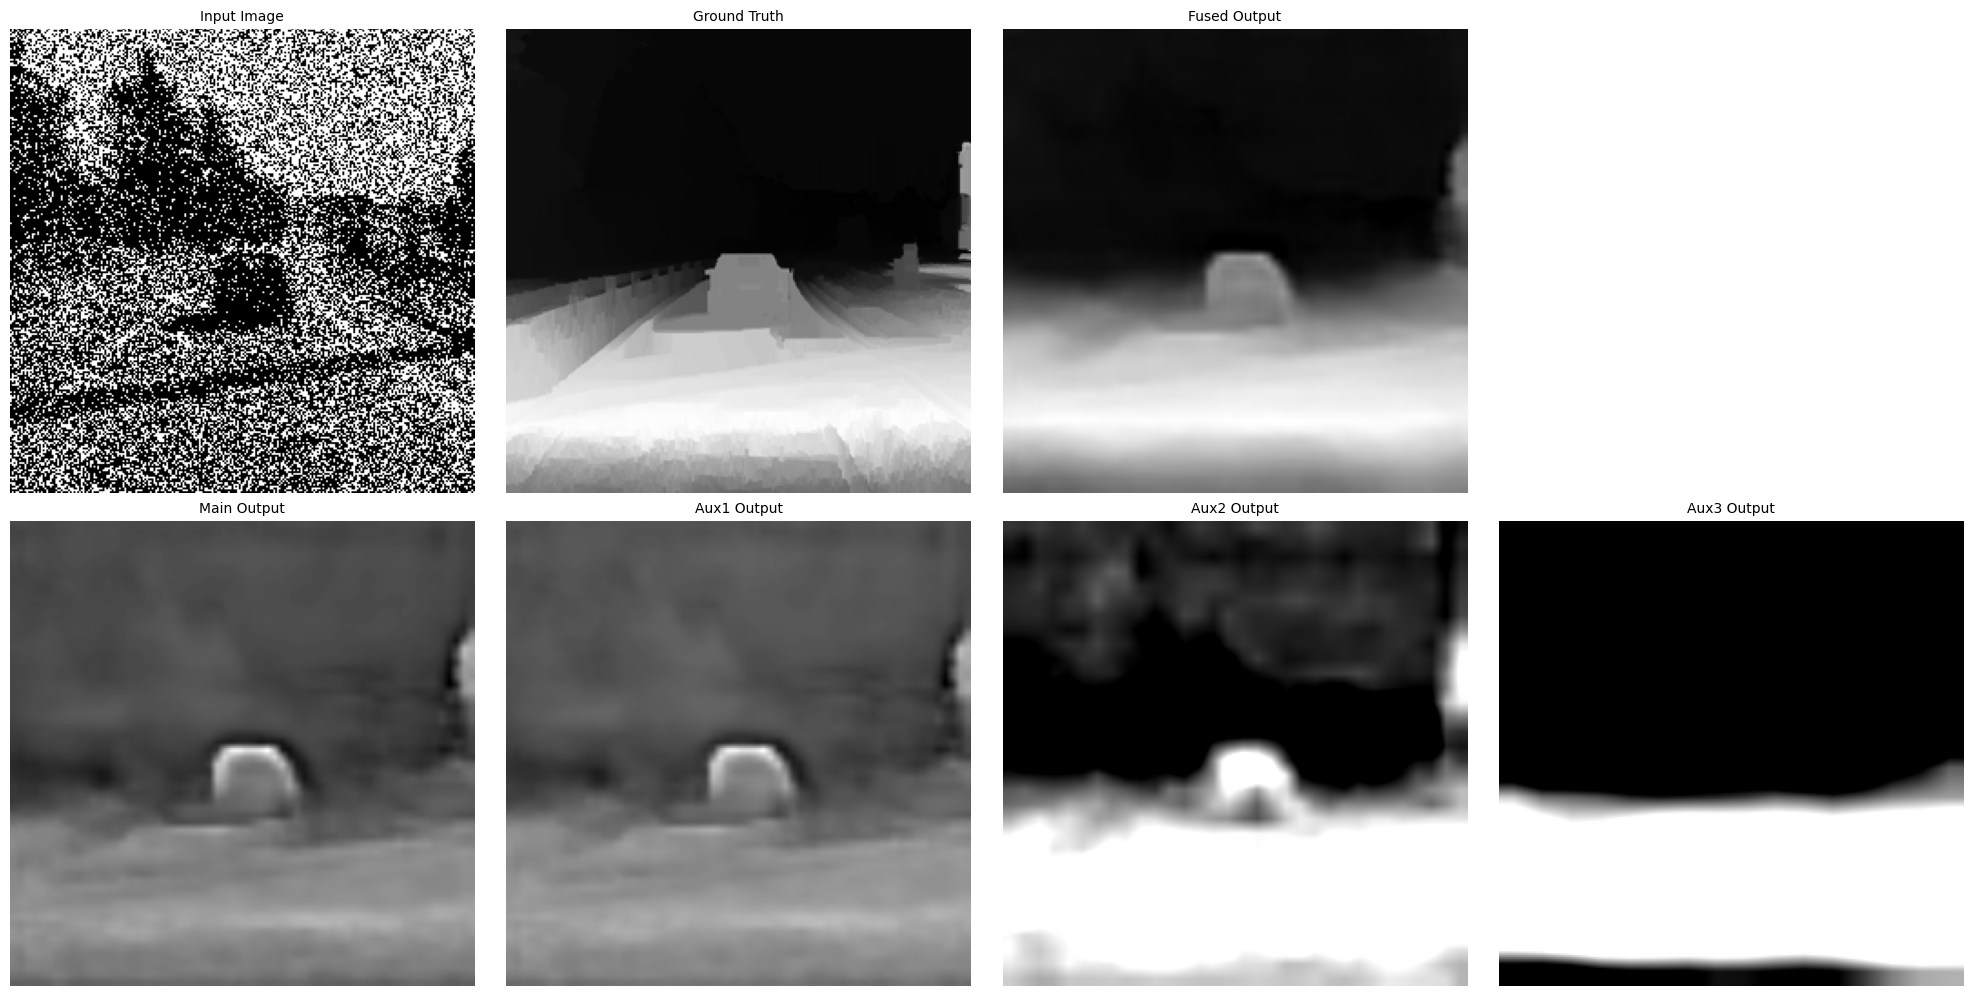

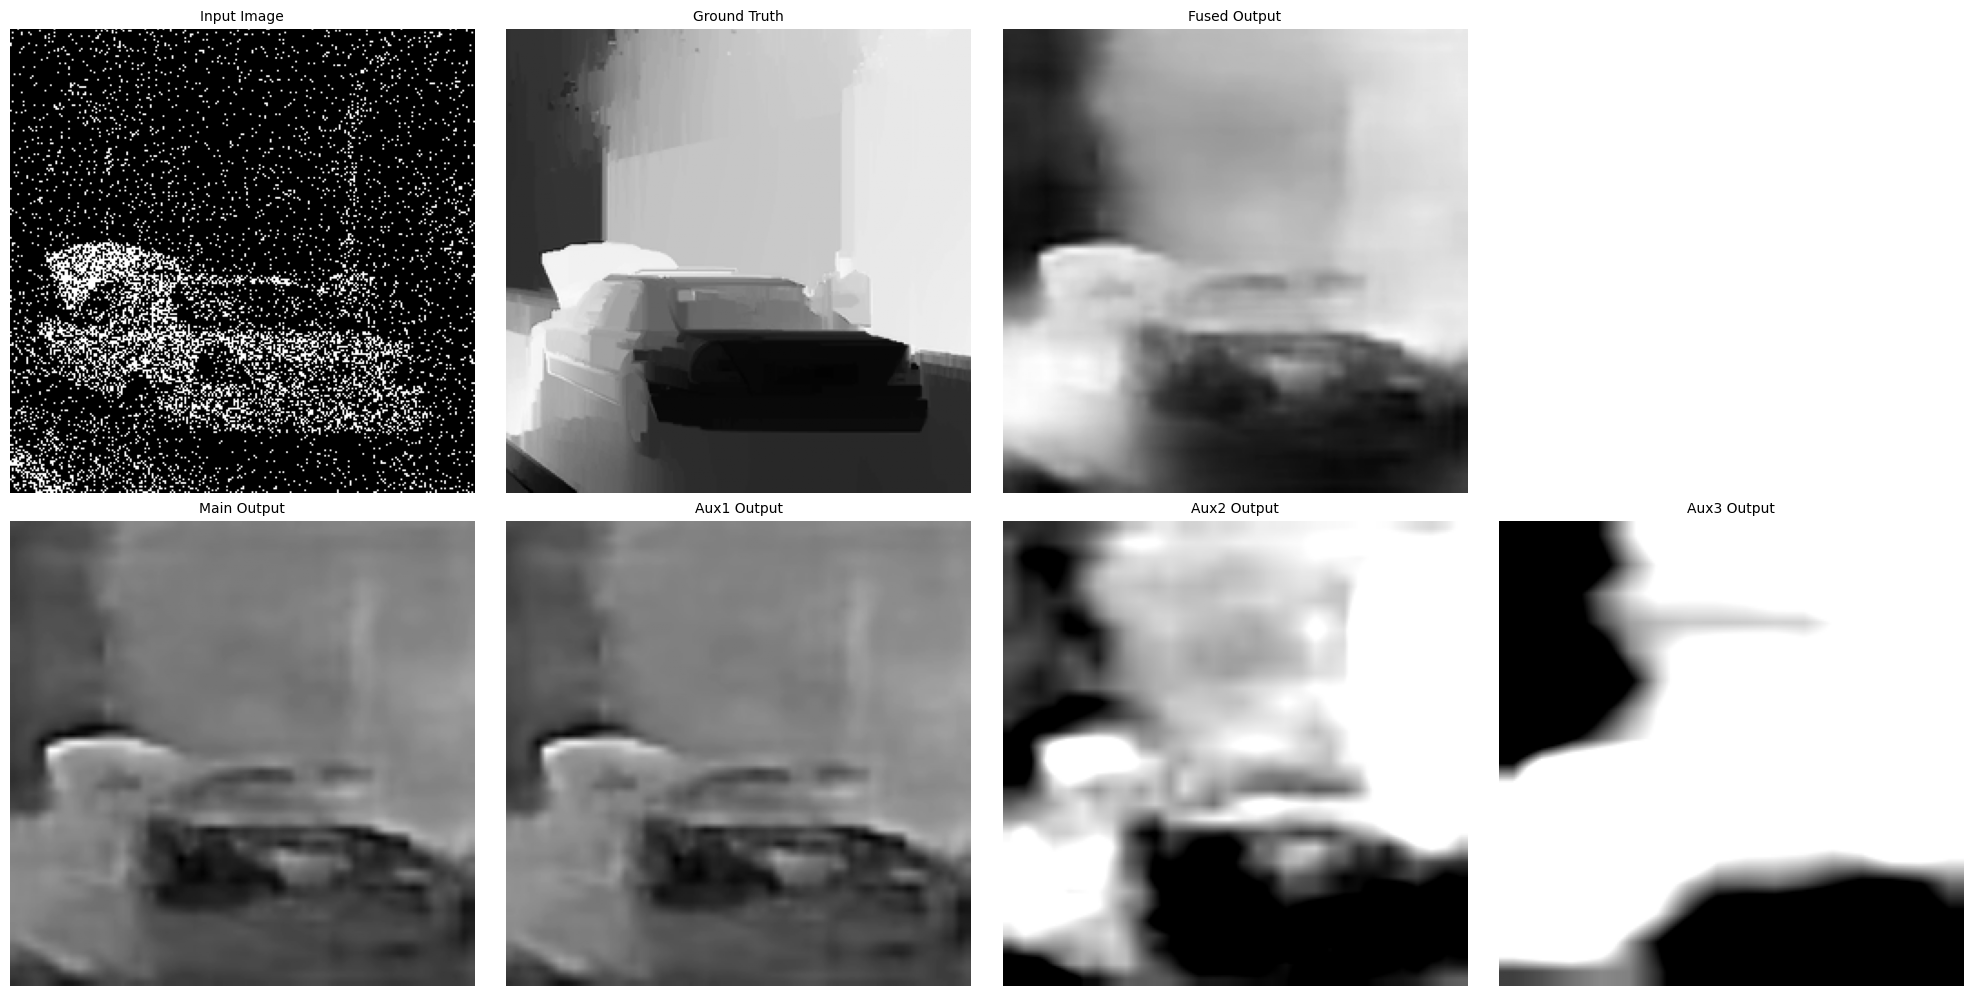

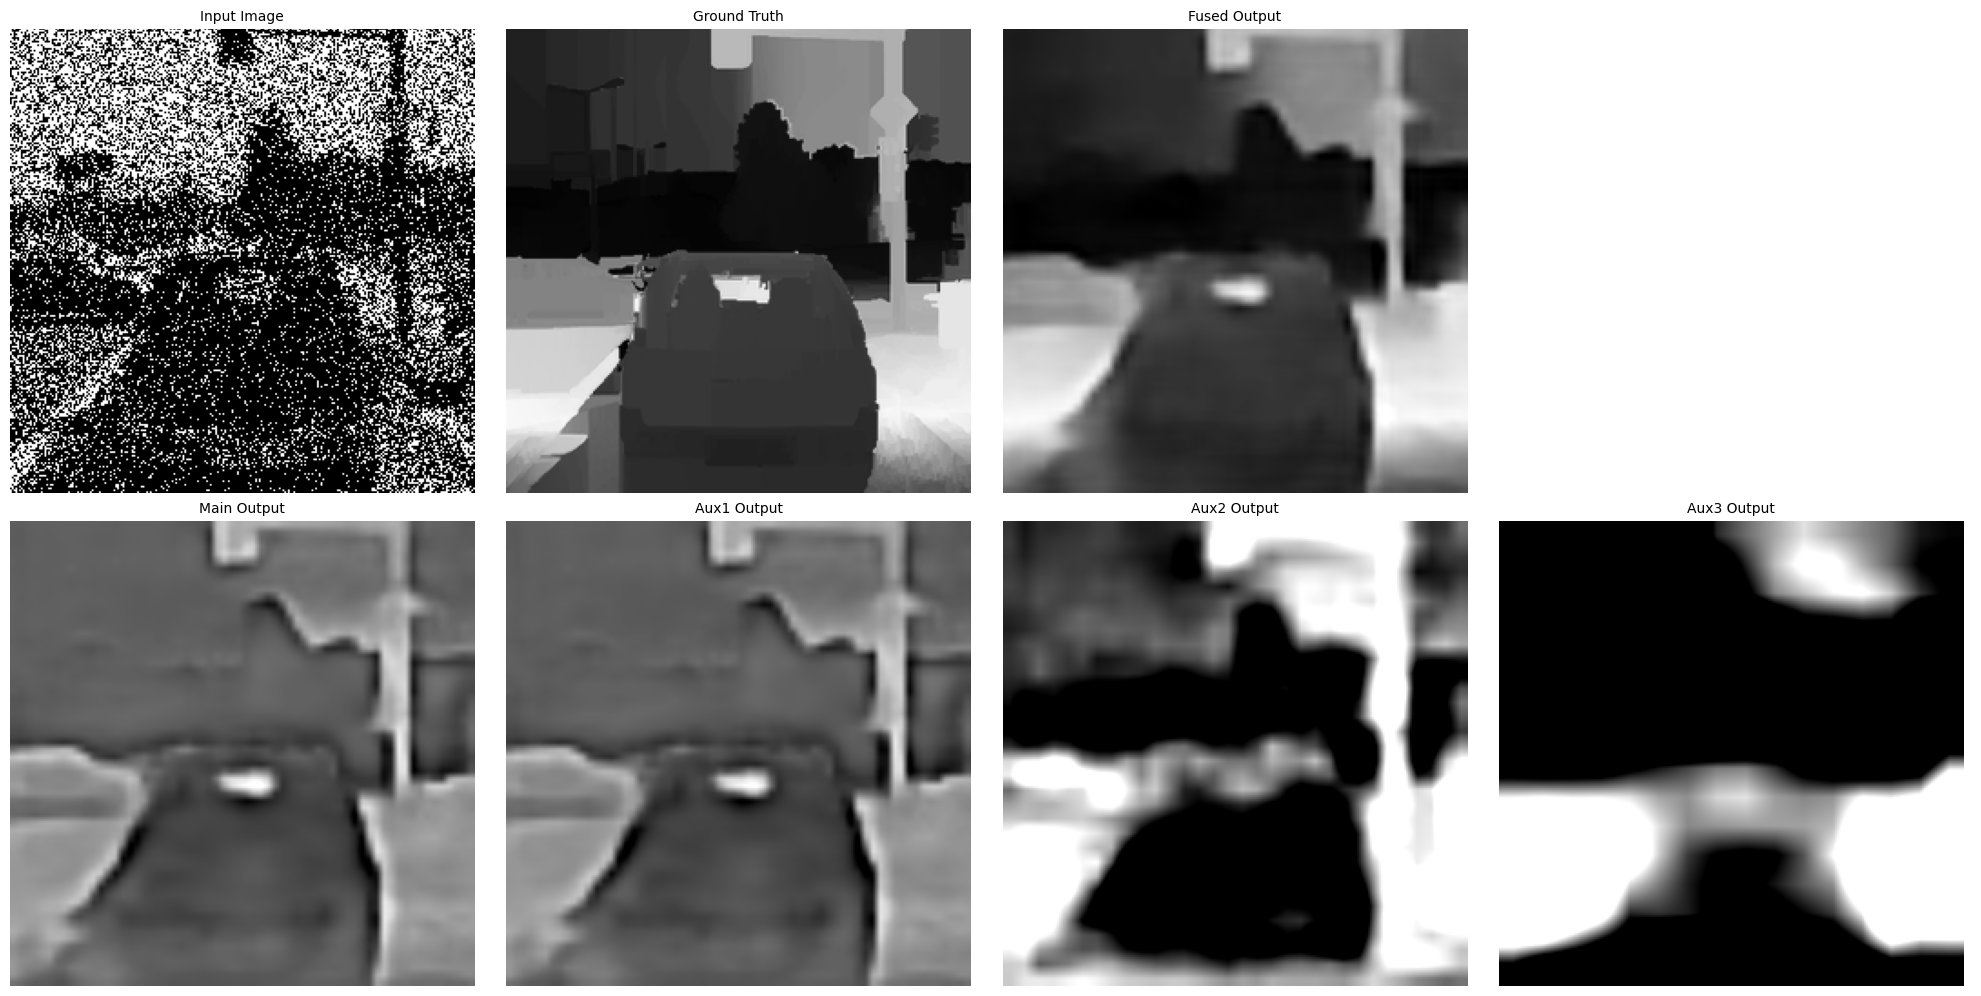

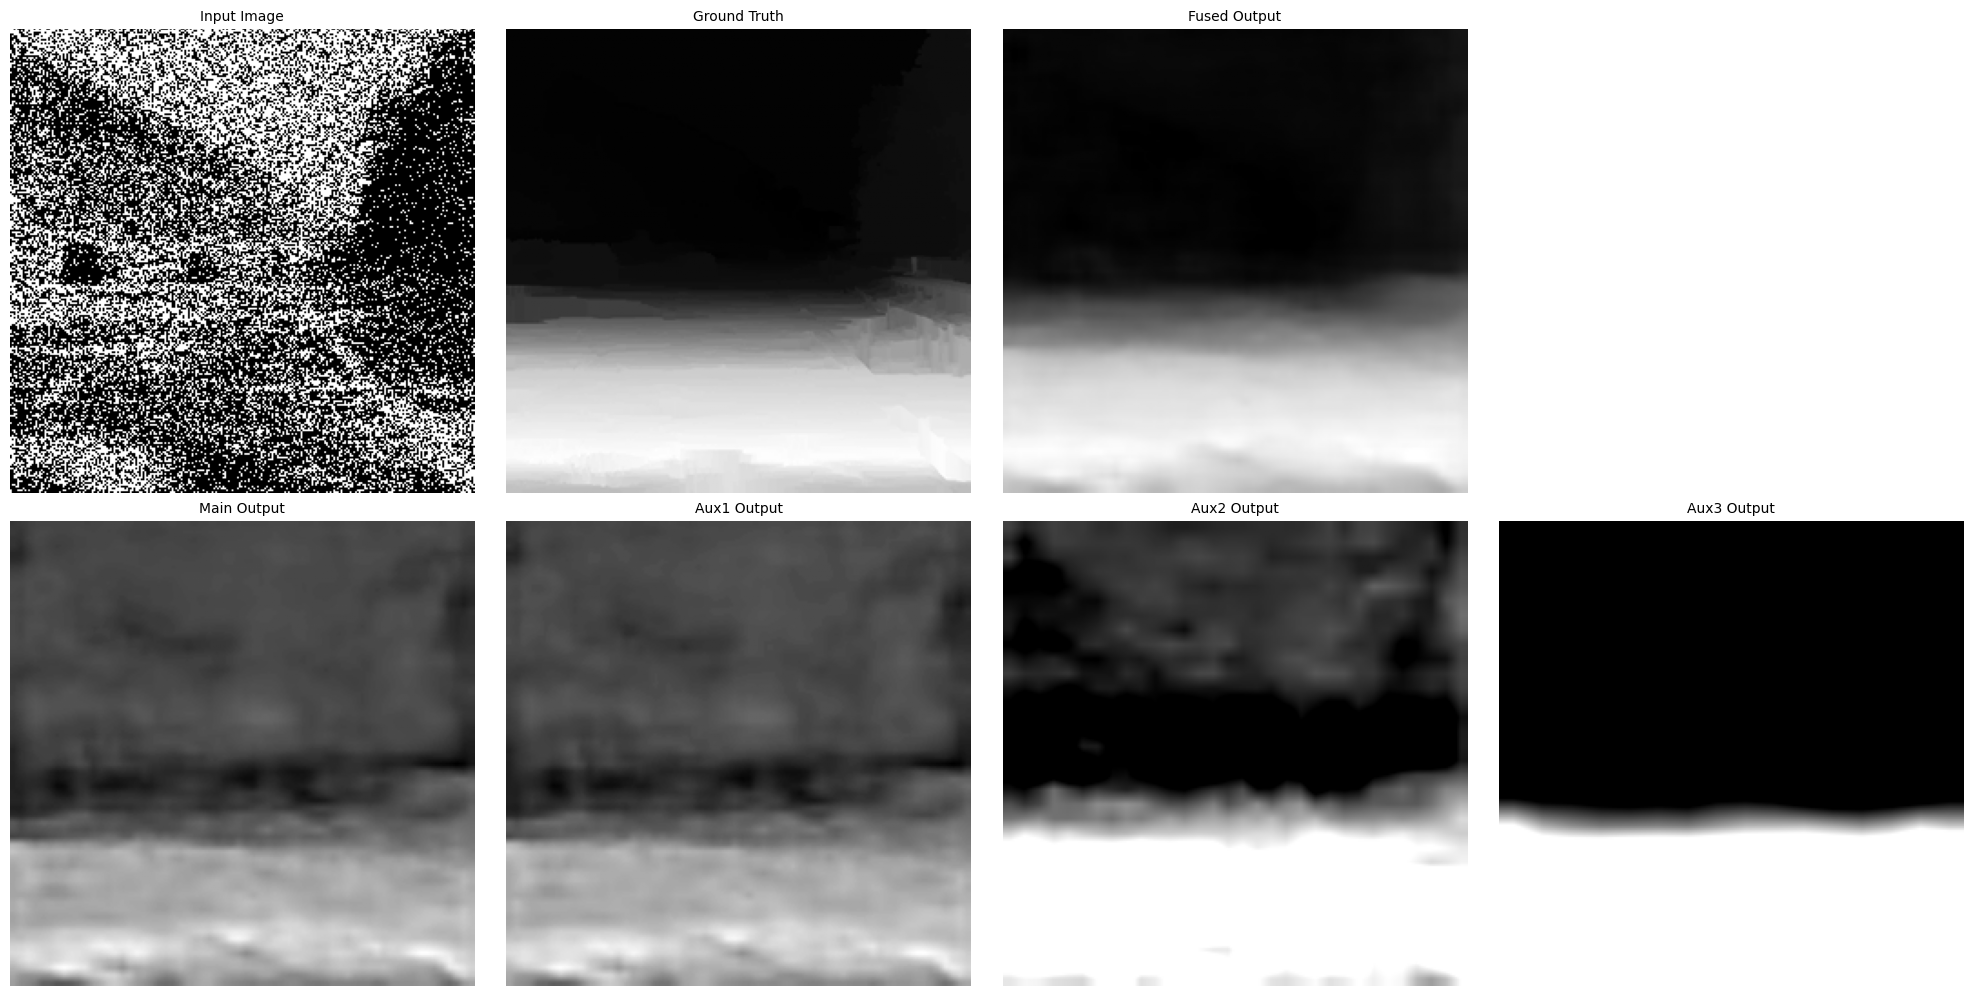

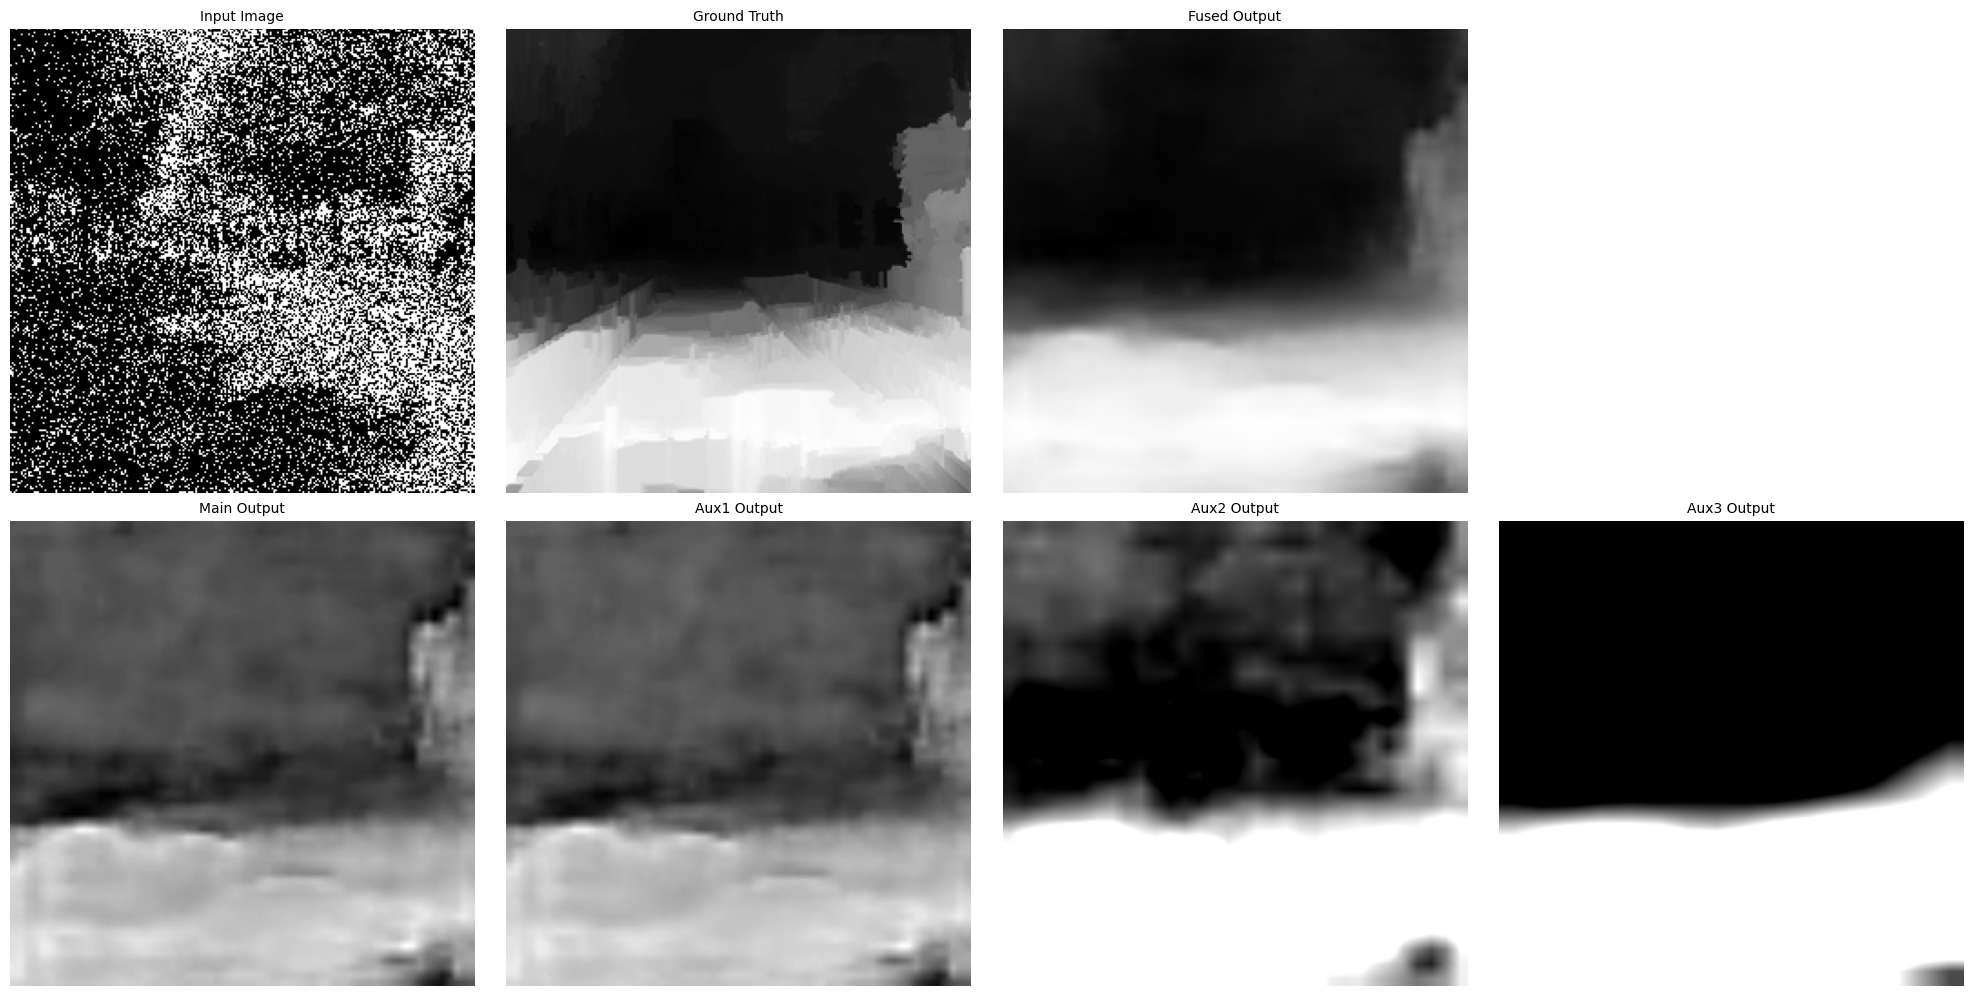

In [20]:
plot_results(model, val_loader, device='mps', num_batches=2)